Import libraries

In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import ArtistAnimation
from matplotlib.animation import FuncAnimation
import io
from PIL import Image

Read the files into pandas dataframes

In [2]:
path = 'data/gps230120g002.hdf5'

file = h5py.File(path, 'r')
dataset = file['Data'].get('Table Layout') # type: ignore
data_array = np.array(dataset)

file.close()

df = pd.DataFrame(data_array)
df['minute'] = df['min']
df['second'] = df['sec']
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])
df = df.drop(['recno','kindat','kinst','ut1_unix','ut2_unix', 'year', 'month', 'day', 'hour', 'minute', 'second', 'min', 'sec'], axis=1)

In [3]:
path = 'data/gps230121g002.hdf5'

file = h5py.File(path, 'r')

dataset = file['Data'].get('Table Layout') # type: ignore
data_array = np.array(dataset)

file.close()

df2 = pd.DataFrame(data_array)
df2['minute'] = df2['min']
df2['second'] = df2['sec']
df2['datetime'] = pd.to_datetime(df2[['year', 'month', 'day', 'hour', 'minute', 'second']])
df2 = df2.drop(['recno','kindat','kinst','ut1_unix','ut2_unix', 'year', 'month', 'day', 'hour', 'minute', 'second', 'min', 'sec'], axis=1)

In [4]:
path = 'data/gps230122g002.hdf5'

file = h5py.File(path, 'r')

dataset = file['Data'].get('Table Layout') # type: ignore
data_array = np.array(dataset)

file.close()

df3 = pd.DataFrame(data_array)
df3['minute'] = df3['min']
df3['second'] = df3['sec']
df3['datetime'] = pd.to_datetime(df3[['year', 'month', 'day', 'hour', 'minute', 'second']])
df3 = df3.drop(['recno','kindat','kinst','ut1_unix','ut2_unix', 'year', 'month', 'day', 'hour', 'minute', 'second', 'min', 'sec'], axis=1)

Join the dataframes

In [5]:
LAT = [55,75]
LONG = [0,30]

df = pd.concat([df, df2, df3], axis=0, ignore_index=True)
df = df.loc[(df['gdlat'] >= LAT[0]) & (df['gdlat'] <= LAT[1]) & (df['glon'] >= LONG[0]) & (df['glon'] <= LONG[1])]
df = df.sort_values(by=['gdlat', 'datetime'], ascending=True)
df

,gdlat,glon,tec,dtec,datetime
12518,55.0,0.0,1.133664,0.584799,2023-01-20 00:02:30
12519,55.0,1.0,2.181003,0.375808,2023-01-20 00:02:30
12520,55.0,2.0,2.382829,0.433729,2023-01-20 00:02:30
12521,55.0,3.0,1.784594,0.654404,2023-01-20 00:02:30
12522,55.0,4.0,2.824801,0.306907,2023-01-20 00:02:30
...,...,...,...,...,...
13272639,75.0,26.0,1.600981,1.305146,2023-01-22 23:57:30
13272640,75.0,27.0,3.044224,0.496190,2023-01-22 23:57:30
13272641,75.0,28.0,3.072824,0.493060,2023-01-22 23:57:30
13272642,75.0,29.0,3.869632,0.923307,2023-01-22 23:57:30


Rolling average

In [6]:
rolling_df = pd.DataFrame()

for long in df['glon'].unique():
    for lat in df['gdlat'].unique():
        df5 = df.loc[(df['gdlat'] == lat) & (df['glon'] == long)]
        moving_avg = df5['tec'].rolling(window=18, min_periods=1, center=True).mean()
        rolling_df = pd.concat([rolling_df, moving_avg], axis=0)

In [7]:
df = pd.concat([df, rolling_df], axis=1)
df['rolling'] = df[0]
df = df.drop(columns=[0])
df['detrended_tec'] = df['tec'] - df['rolling']
df['detrended_tec'].describe()

count    525428.000000
mean         -0.000661
std           0.860997
min          -9.413696
25%          -0.437845
50%          -0.006698
75%           0.429933
max          12.506999
Name: detrended_tec, dtype: float64

Smoothed plot

In [8]:
def create_fig(datetime, df):
    plt.figure(figsize=(8, 6))
    dff = df.loc[df['datetime'] == datetime]
    pivot = dff.pivot('gdlat', 'glon', 'detrended_tec')

    sns.heatmap(pivot, cmap='viridis',vmin=-4, vmax=4)
    #plt.axvline(x=20.53, color='black', lw=3)
    plt.gca().invert_yaxis()

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Baseline removed TEC Heatmap at {datetime}')
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()

    heatmap_array = np.array(Image.open(buf))
    return heatmap_array

def update(frame):
    heatmap = create_fig(frame, df)
    plt.clf()
    plt.imshow(heatmap)

C:\Users\virtanem\AppData\Local\Temp\ipykernel_19592\308561026.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot = dff.pivot('gdlat', 'glon', 'detrended_tec')


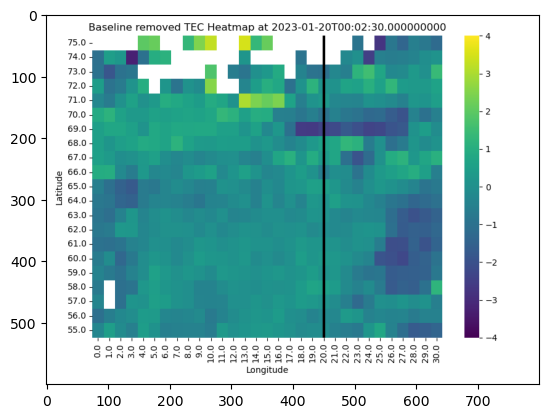

In [9]:
frames = sorted(df['datetime'].unique())
fig, ax = plt.subplots()

# Create the animation using ArtistAnimation
animation = FuncAnimation(fig, update, frames=frames, interval=100)

# Save the animation as a GIF file
#animation.save('heatmap_animation.gif', writer='imagemagick')

# Save the animation as an MP4 file (requires ffmpeg or avconv installed)
animation.save('animations/heatmap_animation_18.mp4', writer='ffmpeg')
